In [1]:
from filterpy.kalman import KalmanFilter, MMAEFilterBank
from filterpy.common import Q_discrete_white_noise
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
import math
from matplotlib import cm

In [2]:
def gen_smooth_trajectory(eta, sigma, length=400):
    ks = np.linspace(0, 2*np.pi, length)
    k2s =  np.linspace(0,length-1, length)
    signals = [np.sin, np.cos]
    num_signals = np.random.randint(2, 50)  

    # Create smoooth trajectory (ground truth)
    smooth_trajectory = np.zeros_like(ks)
    for _ in range(num_signals):
        rand_freq =  np.random.uniform(20, 60) * eta
        rand_amp = np.random.uniform(-5.0, 5.0)
        rand_signal = random.choice(signals)
        phase = np.random.uniform(0, 2*np.pi)
        smooth_trajectory += rand_amp * rand_signal(rand_freq * ks + phase)
    
    # Create noisy trajectory (measurements)
    noise = np.random.normal(0, sigma, length)
    noisy_measurements = smooth_trajectory + noise

    smooth_velocity = np.diff(smooth_trajectory) / np.diff(k2s)
    noisy_velocity = np.diff(noisy_measurements) / np.diff(k2s)
    return np.stack((k2s[0:length-1], smooth_trajectory[0:length-1], smooth_velocity, noisy_measurements[0:length-1], noisy_velocity), axis=-1)


def gen_nonsmooth_trajectory(eta, sigma, length=400):
    ks = np.linspace(0, length-1, length) 

    # Create non-smoooth trajectory (ground truth)
    num_segments = int(np.random.randint(60, 100) * eta)  # Random number of segments
    nonsmooth_trajectory = np.zeros_like(ks)
    segment_length = int(length / num_segments)
    for i in range(num_segments):
        value = np.random.uniform(-10, 10)
        nonsmooth_trajectory[i*segment_length:(i+1)*segment_length] = value
    
    # Create noisy trajectory (measurements)
    noise = np.random.normal(0, sigma, length)
    noisy_measurements = nonsmooth_trajectory + noise

    nonsmooth_velocity = np.diff(nonsmooth_trajectory)
    noisy_velocity = np.diff(noisy_measurements)
    return np.stack((ks[0:length-1], nonsmooth_trajectory[0:length-1], nonsmooth_velocity, noisy_measurements[0:length-1], noisy_velocity), axis=-1)


# sigma = 0.15
# eta = 0.05

# ns_traj = gen_nonsmooth_trajectory(eta, sigma, 400)
# ns_ks = ns_traj[:,0]
# ns_gt = ns_traj[:,1]
# ns_gt_v = ns_traj[:,2]
# ns_nm = ns_traj[:,3]
# ns_nm_v = ns_traj[:,4]

# s_traj = gen_smooth_trajectory(eta, sigma, 400)
# s_ks = s_traj[:,0]
# s_gt = s_traj[:,1]
# s_gt_v = s_traj[:,2]
# s_nm = s_traj[:,3]
# s_nm_v = s_traj[:,4]

# fig, axs = plt.subplots(4)
# fig.suptitle("Nonsmooth and Smooth Trajectories, sigma={:.2f}, eta={:.2f}".format(sigma, eta))

# axs[0].plot(ns_gt)
# axs[0].plot(ns_nm)
# axs[0].set_xlabel("k")
# axs[0].set_ylabel("Position")

# axs[1].plot(ns_nm_v)
# axs[1].set_xlabel("k")
# axs[1].set_ylabel("Velocity")

# axs[2].plot(s_gt)
# axs[2].plot(s_nm)
# axs[2].set_xlabel("k")
# axs[2].set_ylabel("Position")

# axs[3].plot(s_nm_v)
# axs[3].set_xlabel("k")
# axs[3].set_ylabel("Velocity")


# plt.show()

In [3]:
class CostFunctions:
    def P(P0, Q, R, i):
        if i == 0 :
            return P0
        else:
            P_prev = CostFunctions.P(P0, Q, R, i-1)
            return (R*(P_prev + Q)) / (P_prev + Q + R)

    def h_hat(h_hat0, y, P0, Q, R, i):
        if i == 0:
            return h_hat0
        else:
            h_hat_prev = CostFunctions.h_hat(h_hat0, y, P0, Q, R, i-1)
            P_prev = CostFunctions.P(P0, Q, R, i-1)
            return ((P_prev + Q)*(y[i][0] - h_hat_prev)) / (P_prev + Q + R)


    def h(kappa, q, h0, y, P0, R):
        h = np.zeros(kappa)
        for i in range(kappa):
            h[i] = CostFunctions.h_hat(h0, y, P0, q, R, i)
        return h

    def KAPPA_matrix(kappa):
        KAPPA = np.ones((kappa, 3))
        for i in range(kappa):
            delta = i+1
            KAPPA[i] = [1, delta, delta**2]
        return KAPPA

    def K_matrix(kappa):
        KAPPA = CostFunctions.KAPPA_matrix(kappa)
        return KAPPA @ np.linalg.inv( KAPPA.transpose() @ KAPPA ) @ KAPPA.transpose()

    def M_matrix(kappa, epsilon):
        K = CostFunctions.K_matrix(kappa)
        return 2*((1-2*epsilon)*K + epsilon*np.identity(np.shape(K)[0]))

    def J(kappa, epsilon, q, h0, y, P0, R):
        h_hat_j = CostFunctions.h(kappa, q, h0, y, P0, R)
        h_hat_j = np.expand_dims(h_hat_j, axis=0)
        h_hat_j = h_hat_j.transpose()
        M = CostFunctions.M_matrix(kappa, epsilon)
        K=  CostFunctions.K_matrix(kappa)
        J = 0.5 * h_hat_j.transpose() @ M @ h_hat_j - 2*(1-epsilon)*y.transpose() @ K @ h_hat_j
        return J
    
    def J_fixed(q, h0, y, P0, R):
        h1 = ((P0+q)*(y[1][0]-h0))/(P0+q+R)
        h2 = (((y[2][0]*(P0+q+R) -  (y[1][0]-h0)*(P0+q))*(P0*R+(P0+q+2*R)*q))/((P0+q+R)*(2*P0*R + (P0+q+3*R)*q +R**2)))
        return 0.5*(h0**2 + h1**2 + h2**2) - (h0*y[0][0] + h1*y[1][0] + h2*y[2][0])

    def q_graph(kappa: float, epsilon, y_k, h0, P0, R, qs):
        Js = np.zeros_like(qs)
        for i in range(n):
            Js[i] = CostFunctions.J(kappa, epsilon, qs[i], h0, y_k, P0, R)
        opt_q = qs[np.where(Js==min(Js))]
        plt.plot(qs, Js, 'k-',label='cost')
        plt.axvline(opt_q)
        plt.legend()

    def q_opt(kappa: float, epsilon, y_k, h0, P0, R, qs):
        J_min = CostFunctions.J(kappa, epsilon, qs[0], h0, y_k, P0, R)
        q_opt = qs[0]
        for q in qs:
            cost = CostFunctions.J(kappa, epsilon, q, h0, y_k, P0, R)[0][0]
            if cost < J_min:
                J_min = cost
                q_opt = q
        return q_opt

In [4]:
# Trajectories for tests
ETAS = np.arange(0.05, 0.5 + 0.01, 0.05)
SIGMAS = np.arange(0.05, 1.4 + 0.01, 0.15)
# ETAS = np.array([0.15, 0.2, 0.25, 0.3])
# SIGMAS = np.array([0.85, 1, 1.15, 1.3])

n_iter = 75
n_traj = 2
window_size = 5

trajectories = {}
errors = {}
for sigma in SIGMAS:
    trajectories[sigma] = {}
    errors[sigma] = {}
    for eta in ETAS:
        trajectories[sigma][eta] = {
            "smooth": [],
            "nonsmooth": [],
        }
        errors[sigma][eta] = {
            "smooth_oae": [],
            "nonsmooth_oae": [],
            "smooth_mmae": [],
            "nonsmooth_mmae": [],
        }
        for i in range(n_traj):
            ns_traj = gen_nonsmooth_trajectory(eta, sigma, n_iter+1)
            s_traj = gen_smooth_trajectory(eta, sigma, n_iter+1)
            trajectories[sigma][eta]["smooth"].append(s_traj)
            trajectories[sigma][eta]["nonsmooth"].append(ns_traj)

In [5]:
def filter(q, R, dt=1.):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])
    kf.F = np.array([[1.,dt],
                    [0.,1.]])
    kf.H = np.array([[1.,0.]])
    kf.P = np.array([[1000.,    0.],
                    [   0., 1000.] ])
    kf.R = R
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=q)
    return kf

In [6]:
qs = [0, 0.1, 1, 10]
q_grid = np.linspace(0, 10, 100)

for sigma, etas in trajectories.items():
    for eta, traj_types in etas.items():
        for traj_type, trajs in traj_types.items():
            for traj in trajs:
                epsilon = 0.5
                filters = []
                p = []

                for q in qs:
                    filters.append(filter(q, float(sigma)))
                    p.append(1/len(qs))

                kfMMAE = MMAEFilterBank(filters, p, filters[0].dim_x, filters[0].H)
                kfOAE = filter(qs[0], float(sigma))

                exm = np.zeros(n_iter)
                evm = np.zeros(n_iter)
                
                exa = np.zeros(n_iter-window_size)
                eva = np.zeros(n_iter-window_size)

                z_window = collections.deque(maxlen=2*window_size+1)
                h_queue = collections.deque(maxlen=window_size+1)
                P_queue = collections.deque(maxlen=window_size+1)

                # Generate Observations
                X = traj[:, 1:3]
                X = np.reshape(X, (len(X), 2, 1))
                Z = traj[:,3]

                for k in range(0, n_iter):
                    z = Z[k]
                    z_window.append(z)

                    kfMMAE.predict()
                    kfMMAE.update(z)
                    exm[k] = kfMMAE.x[0]
                    evm[k] = kfMMAE.x[1]
                    
                    if k >= 2*window_size:
                        q = CostFunctions.q_opt(2*window_size+1, epsilon, np.array([list(z_window)]).transpose(), h_queue[0], P_queue[0], float(sigma), q_grid)
                        kfOAE.Q = Q_discrete_white_noise(dim=2, dt=1, var=q*4)
                    
                    if k >= window_size:
                        kfOAE.predict()
                        kfOAE.update(z_window[len(h_queue)])
                        h_queue.append(kfOAE.x[0])
                        P_queue.append(kfOAE.P[0,0])
                        exa[k-window_size] = kfOAE.x[0]
                        eva[k-window_size] = kfOAE.x[1]

                est_x_oae = exa[window_size+1:-1]
                est_x_mmae = exm[window_size+2:-window_size]
                true_x = X[window_size+2:-window_size,0,0]
                iter_times = traj[window_size+2:-window_size,0]

                # plt.figure(figsize=(10,5))
                # plt.subplot(1, 2, 1)
                # plt.title("System Position")
                # plt.plot(iter_times, true_x, color='k',label='truth value')
                # plt.plot(iter_times, est_x_mmae, 'r-',label='MMAE')
                # plt.plot(iter_times, est_x_oae, 'b-',label='OAE')
                # plt.legend()
                # plt.savefig(f'plots/{traj_type}{sigma}{eta}.png')
                # plt.close()

                norm_err_oae = np.linalg.norm(true_x - est_x_oae)
                norm_err_mmae = np.linalg.norm(true_x - est_x_mmae)
                norm_meas = np.linalg.norm(true_x)

                normalized_err_oae = norm_err_oae / norm_meas
                normalized_err_mmae = norm_err_mmae / norm_meas
                errors[sigma][eta][traj_type + "_oae"].append(normalized_err_oae)
                errors[sigma][eta][traj_type + "_mmae"].append(normalized_err_mmae)

                # print("Sigma:", sigma, "Eta:", eta, "Norm_err_oae:", normalized_err_oae)
                # print("Sigma:", sigma, "Eta:", eta, "Norm_err_mmae:", normalized_err_mmae)
                # print("MMAE - OAE = ",normalized_err_mmae - normalized_err_oae )
            

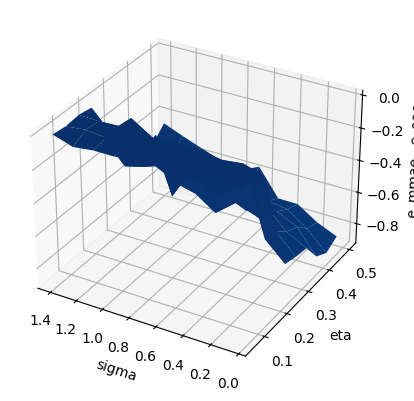

In [7]:
_SIGMAS = SIGMAS
_ETAS = ETAS
_SIGMAS, _ETAS = np.meshgrid(_SIGMAS, _ETAS)
SMOOTH_ERRS = np.zeros_like(_SIGMAS)
NONSMOOTH_ERRS = np.zeros_like(_SIGMAS)

SMOOTH_RATIO = np.zeros_like(_SIGMAS)
NONSMOOTH_RATIO = np.zeros_like(_SIGMAS)

for row_idx in range(len(SMOOTH_ERRS)):
    __row = SMOOTH_ERRS[row_idx]
    __eta = ETAS[row_idx]
    for col_idx in range(len(__row)):
        __sigma = SIGMAS[col_idx]

        smooth_err_mmae = np.mean(np.array(errors[__sigma][__eta]["smooth_mmae"]))
        smooth_err_oae = np.mean(np.array(errors[__sigma][__eta]["smooth_oae"]))
        smooth_delta = smooth_err_mmae - smooth_err_oae
        smooth_ratio = smooth_err_oae / smooth_err_mmae
        SMOOTH_ERRS[row_idx][col_idx] = smooth_delta
        SMOOTH_RATIO[row_idx][col_idx] = smooth_ratio
        # print("Sigma, Eta, smooth_err_mmae, smooth_err_oae:", __sigma, __eta, smooth_err_mmae, smooth_err_oae)

        nonsmooth_err_mmae = np.mean(np.array(errors[__sigma][__eta]["nonsmooth_mmae"]))
        nonsmooth_err_oae = np.mean(np.array(errors[__sigma][__eta]["nonsmooth_oae"]))
        nonsmooth_delta = nonsmooth_err_mmae - nonsmooth_err_oae
        nonsmooth_ratio = nonsmooth_err_oae / nonsmooth_err_mmae
        NONSMOOTH_ERRS[row_idx][col_idx] = nonsmooth_delta
        NONSMOOTH_RATIO[row_idx][col_idx] = nonsmooth_ratio
        
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(_SIGMAS, _ETAS, SMOOTH_ERRS, vmin=Z.min() * 2, cmap=cm.Blues)

ax.set(xlabel="sigma")
ax.invert_xaxis()
ax.set(ylabel="eta")
ax.set(zlabel="e_mmae - e_oae")
plt.show()

# print(np.mean(SMOOTH_RATIO))
# print(np.mean(NONSMOOTH_RATIO))

90.59136090603657
330.27010472327595


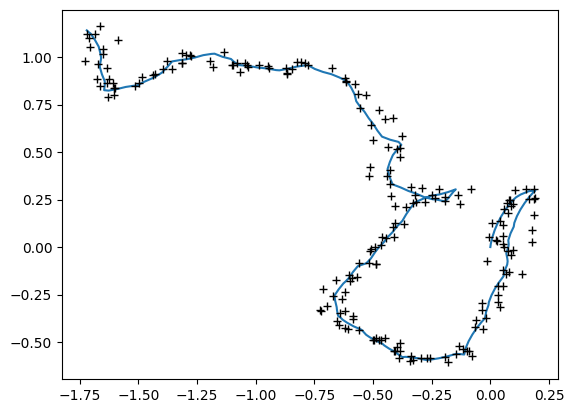

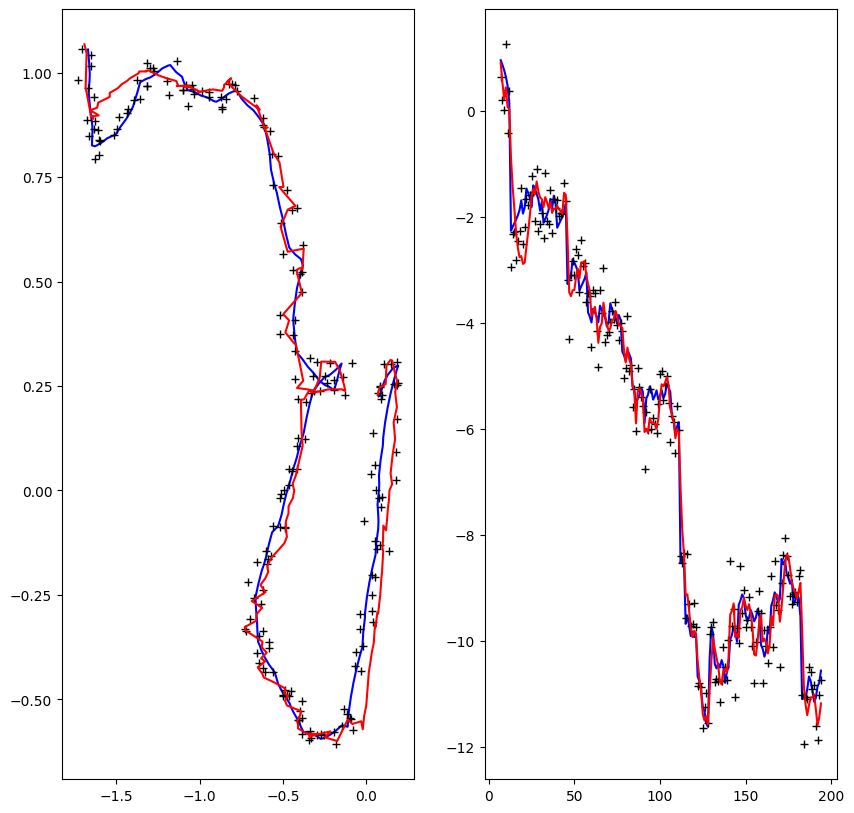

In [8]:
qs = [0, 0.1, 1, 10]
q_grid = np.linspace(0, 10, 100)


def unicycle_dynamic_data(n, phi_initial, x_initial, y_initial, dt):
    t = []
    phi = []
    x = []
    y = []
    
    for i in range(n):
        t.append(i)

        if len(phi) ==0 :
            phi_i = phi_initial
            x_i = x_initial
            y_i = y_initial
        else:
            phi_i = phi[i-1]
            x_i = x[i-1]
            y_i = y[i-1]

        phi.append(phi_i + 0.5*math.pow(dt,2)*(-1.8/math.sin(pow(phi_i,2))))
        u = min(abs(math.tan(4*phi_i)), 1)
        x.append(x_i + 0.5*math.pow(dt,2) * u*math.cos(phi_i))
        y.append(y_i + 0.5*math.pow(dt,2) * u*math.sin(phi_i))

    sigma_multiplier = 0.05
    sigma_x = sigma_multiplier*abs(0.5*np.mean(x))
    sigma_y = sigma_multiplier*abs(0.5*np.mean(y))
    sigma_phi = sigma_multiplier*abs(0.5*np.mean(phi))

    x_noise = np.random.normal(0, 0.15*abs(0.5*np.mean(x)), n)
    y_noise = np.random.normal(0, 0.15*abs(0.5*np.mean(y)), n)
    phi_noise = np.random.normal(0, 0.15*abs(0.5*np.mean(phi)), n)

    x_with_noise = x+x_noise
    y_with_noise = y+y_noise
    phi_with_noise = phi+phi_noise

    return t, x, y, phi, x_with_noise, y_with_noise, phi_with_noise, sigma_x, sigma_y, sigma_phi


epsilon = 0.82
n_iters = 200
window_size = 5
dt=0.275

t, x, y, phi, x_with_noise, y_with_noise, phi_with_noise, sigma_x, sigma_y, sigma_phi = unicycle_dynamic_data(n_iters, math.pi/2, 0, 0, dt)


plt.plot(x, y)
plt.plot(x_with_noise, y_with_noise, 'k+')


# Run Kalman Filter
filter_x  = filter(qs[0], float(sigma_x)**2, dt)
filter_y  = filter(qs[0], float(sigma_y)**2, dt)
filter_phi  = filter(qs[0], float(sigma_phi)**2, dt)

zx_window = collections.deque(maxlen=2*window_size+1)
hx_queue = collections.deque(maxlen=window_size+1)
Px_queue = collections.deque(maxlen=window_size+1)

zy_window = collections.deque(maxlen=2*window_size+1)
hy_queue = collections.deque(maxlen=window_size+1)
Py_queue = collections.deque(maxlen=window_size+1)

zphi_window = collections.deque(maxlen=2*window_size+1)
hphi_queue = collections.deque(maxlen=window_size+1)
Pphi_queue = collections.deque(maxlen=window_size+1)

ex = np.zeros(n_iters-window_size)
ey = np.zeros(n_iters-window_size)
ephi = np.zeros(n_iters-window_size)

for k in range(0, n_iters):
    x_k = x_with_noise[k]
    y_k = y_with_noise[k]
    phi_k = phi_with_noise[k]

    zx_window.append(x_k)
    zy_window.append(y_k)
    zphi_window.append(phi_k)

    if k >= 2*window_size:
        # filter_x
        q_x = CostFunctions.q_opt(2*window_size+1, epsilon, np.array([list(zx_window)]).transpose(), hx_queue[0], Px_queue[0], float(sigma_x)**2, q_grid)
        filter_x.Q = Q_discrete_white_noise(dim=2, dt=dt, var=q_x)
        # filter_y
        q_y = CostFunctions.q_opt(2*window_size+1, epsilon, np.array([list(zy_window)]).transpose(), hy_queue[0], Py_queue[0], float(sigma_y)**2, q_grid)
        filter_y.Q = Q_discrete_white_noise(dim=2, dt=dt, var=q_y)
        # filter_z
        q_phi = CostFunctions.q_opt(2*window_size+1, epsilon, np.array([list(zphi_window)]).transpose(), hphi_queue[0], Pphi_queue[0], float(sigma_phi)**2, q_grid)
        filter_phi.Q = Q_discrete_white_noise(dim=2, dt=dt, var=q_phi)

    if k >= window_size:
        # filter_x
        filter_x.predict()
        filter_x.update(zx_window[len(hx_queue)])
        hx_queue.append(filter_x.x[0])
        Px_queue.append(filter_x.P[0,0])
        ex[k-window_size] = filter_x.x[0]
        # filter_y
        filter_y.predict()
        filter_y.update(zy_window[len(hy_queue)])
        hy_queue.append(filter_y.x[0])
        Py_queue.append(filter_y.P[0,0])
        ey[k-window_size] = filter_y.x[0]
        # filter_phi
        filter_phi.predict()
        filter_phi.update(zphi_window[len(hphi_queue)])
        hphi_queue.append(filter_phi.x[0])
        Pphi_queue.append(filter_phi.P[0,0])
        ephi[k-window_size] = filter_phi.x[0]


ex = ex[window_size+1:-1]
x = x[window_size+2:-window_size]
x_with_noise = x_with_noise[window_size+2:-window_size]

ey = ey[window_size+1:-1]
y = y[window_size+2:-window_size]
y_with_noise = y_with_noise[window_size+2:-window_size]

ephi = ephi[window_size+1:-1]
phi = phi[window_size+2:-window_size]
phi_with_noise = phi_with_noise[window_size+2:-window_size]

t = t[window_size+2:-window_size]

print(np.var(ex-x)/np.var(x-x_with_noise) *100) 
print(np.var(ey-y)/np.var(y-y_with_noise) *100) 

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(x, y, 'b')
plt.plot(x_with_noise, y_with_noise, 'k+')
plt.plot(ex, ey, 'r')
plt.subplot(1, 2, 2)
plt.plot(t, phi, 'b')
plt.plot(t, phi_with_noise, 'k+')
plt.plot(t, ephi, 'r')